# Team Members

Dhagash Desai, Lina Hashem

# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Tuple
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from tqdm import tqdm
from utils import array_to_one_hot
from sklearn.metrics import accuracy_score
import pickle

# Dataloader

In [2]:
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
BATCH_SIZE = 20
SHUFFLE = True

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

# Model

In [4]:
class TwoLayerNet():

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int,load_config):

        if load_config:
          config_load = open(
              "twolayer_mnist_weights_epcoh_300.pkl", "rb")

          self.params = pickle.load(config_load)

        else:

          self.params = {}

        self.params['w1'] = np.random.uniform(-0.5, 0.5, (input_dim, hidden_dim))
        self.params['w2'] = np.random.uniform(-0.5, 0.5, (hidden_dim, output_dim))


        

    def sigmoid_function(self, x: np.ndarray):

        return 1 / (1 + np.exp(-x))

    def sigmoid_function_backward(self, x: np.ndarray):

        output = self.sigmoid_function(x) * (1 - self.sigmoid_function(x))

        return output

    def softmax_function(self, x: np.ndarray):

        exp = np.exp(x)
        sumexp = np.sum(exp, axis=1, keepdims=True)

        output = exp/(sumexp)

        return output

    def softmax_function_backward(self, x: np.ndarray, y: np.ndarray):

        s = self.y_pred
        output = np.zeros((x.shape[0], x.shape[1]))

        for i in range(x.shape[0]):

            s_vector = s[i].reshape((s[i].shape[0], 1))
            s_matrix = np.tile(s_vector, s[i].shape[0])
            softmax_derivative = np.sum(
                (s[i]-y[i]) * (np.diag(s[i]) - (s_matrix * np.transpose(s_matrix))), axis=1)
            output[i] = softmax_derivative

        return output

    def linear_backward_x(self, upstream_grad: np.ndarray, w: np.ndarray):

        dx = np.dot(upstream_grad, w.T)

        return dx

    def linear_backward_w(self, upstream_grad, x):

        dw = np.dot(x.T, upstream_grad)

        return dw

    def forward(self, X: np.ndarray):

        self.x = X
        self.layer_1 = self.x @ self.params['w1']
        self.sigmoid_layer = self.sigmoid_function(self.layer_1)
        self.layer_2 = self.sigmoid_layer @ self.params['w2']
        self.y_pred = self.softmax_function(self.layer_2)

        return self.y_pred

    def backward(self, y: np.ndarray):

        softmax_backward = self.softmax_function_backward(self.layer_2, y)
        linear_layer2_backward_x = self.linear_backward_x(softmax_backward, self.params['w2'])
        sigmoid_backward = self.sigmoid_function_backward(self.layer_1)
        sigmoid_backward = linear_layer2_backward_x * sigmoid_backward

        dw2 = 1 / y.shape[0] * self.linear_backward_w(softmax_backward, self.sigmoid_layer) 
        dw1 = 1 / y.shape[0] * self.linear_backward_w(sigmoid_backward, self.x)

        #Update gradients

        self.params['w1'] = self.params['w1'] - (self.learning_rate * dw1)
        self.params['w2'] = self.params['w2'] - (self.learning_rate * dw2)


    def loss_mse(self, y_pred: np.ndarray, y: np.ndarray):

        return np.mean((y_pred - y) ** 2)

    def train(self, num_iterations, train_dataloader, learning_rate):

        loss_train = []

        self.learning_rate = learning_rate
        progress_bar = tqdm(range(num_iterations), total=num_iterations)
        loss_train = []

        for t in progress_bar:

            loss = 0.0

            for imgs, labels in train_dataloader:

                X_batch = imgs.squeeze().reshape(
                    (imgs.shape[0], np.prod(imgs.shape[1:], axis=0))).numpy()
                y_batch = array_to_one_hot(labels.numpy(), 10)

                output = self.forward(X_batch)

                loss_batch = self.loss_mse(output, y_batch)

                self.backward(y_batch)

                loss += loss_batch
            loss_train.append(loss)
            progress_bar.set_description(f"Iter {t+1}: loss {loss:.5f}. ")
            
            #Saving params so that it can be loaded afterwards
            if (t%100 == 0) & (t != 0):

                filename = "twolayer_mnist_weights_epcoh_%d.pkl"%(t)

                with open(filename,'wb') as f:
                    pickle.dump(self.params,f)

        return loss_train


# Train

In [5]:
model = TwoLayerNet(784,64,10,False)
loss = model.train(400,train_loader,1e-1)
# Saving Loss Progress
np.savetxt('loss_progress.txt',np.array(loss))

Iter 400: loss 2.06811. : 100%|██████████| 400/400 [53:33<00:00,  8.03s/it]


# Test

In [10]:
def test(test_dataloader, model):

    predict_correct = 0.0

    for imgs, labels in test_dataloader:

        X_batch = imgs.squeeze().reshape(
            (imgs.shape[0], np.prod(imgs.shape[1:], axis=0))).numpy()

        output = model.forward(X_batch)

        predictions = np.argmax(output, axis=1)

        correct_batch = accuracy_score(
            labels, predictions, normalize=False)
        predict_correct += correct_batch

    acc = (predict_correct / (len(test_dataset))) * 100
    
    return acc

In [11]:
acc = test(test_loader, model)
print("The accuracy of the model on test dataset is %f"%(acc))

The accuracy of the model on test dataset is 96.990000


In [21]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=SHUFFLE)

In [26]:
# Test Output Samples

it = iter(test_loader)

for i in range(5):

    img,label= next(it)
    img = img.squeeze().reshape(
        (img.shape[0], np.prod(img.shape[1:], axis=0))).numpy()
    output = model.forward(img)
    label = label.numpy()[0]
    prediction = np.argmax(output)
    

    print("The prediction from network is %d and the ground truth is %d"%(prediction,label))

The prediction from network is 5 and the ground truth is 5
The prediction from network is 3 and the ground truth is 3
The prediction from network is 0 and the ground truth is 0
The prediction from network is 9 and the ground truth is 9
The prediction from network is 1 and the ground truth is 1


# Plots

Text(0.5, 1.0, 'Training Progress(Linear Scale')

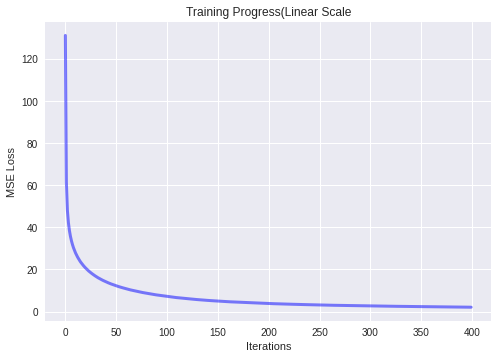

In [12]:
# Loss Plot

plt.style.use('seaborn')

plt.plot(loss, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Progress(Linear Scale')